In [105]:
import numpy as np
import onnxruntime as ort
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import export_text, DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz
import graphviz
from sklearn.preprocessing import LabelEncoder
import os
import glob
import matplotlib.pyplot as plt

In [72]:
# === Configuration for all agents ===
AGENT_CONFIG = {
    "food": {
        "onnx_path": "Food\Food_with_logits.onnx",
        "obs_bin_path": r"Food\foodAgentObs.bin",
        "action_path": r"Food\foodAgentObs_actions.npy",  # Optional
        "obs_shape": (-1, 40, 40, 5),
        "num_discrete": 2,
        "num_continuous": 3,
        "is_multi_agent": False,
        "action_names": ["No Shoot", "Shoot"],
    },
    "pyramid": {
        "onnx_path": "Pyramids\Pyramids2_with_logits.onnx",
        "obs_bin_path": "Pyramids\AgentObservations.bin",
        "action_path": "Pyramids\AgentActions.bin",
        "obs_shape": (-1, 172),
        "num_discrete": 5,
        "num_continuous": 0,
        "is_multi_agent": False,
        "action_names": ["No Action", "Move Forward", "Move Backward", "Turn Right", "Turn Left"],
    },
    "dungeon": {
        "onnx_path": "Dungeon\Dungeon_with_logits.onnx",
        "obs_bin_glob": "Dungeon\AgentObservations_Agent*.bin",
        "action_path_glob": "Dungeon\AgentActions_Agent*.bin",  # 3 files expected
        "obs_shape": (-1, 410),
        "num_discrete": 7,
        "num_continuous": 0,
        "is_multi_agent": True,
        "action_names": ["No Action", "Move Forward", "Move Backward", "Turn Right", "Turn Left", "Strafe Left", "Strafe Right"],
    }
}

In [73]:
def load_observations(bin_path, shape):
    with open(bin_path, "rb") as f:
        raw = f.read()
    arr = np.frombuffer(raw, dtype=np.float32)

    feature_size = int(np.prod(shape[1:]))
    total_samples = len(arr) // feature_size  # drop partials

    if len(arr) % feature_size != 0:
        print(f"⚠️ Warning: {bin_path} has trailing bytes — trimming {len(arr) % feature_size} floats.")

    trimmed = arr[:total_samples * feature_size]
    return trimmed.reshape((total_samples, *shape[1:]))

In [74]:
def run_onnx_inference(onnx_path, observations, num_discrete_actions):
    session = ort.InferenceSession(onnx_path)
    input_names = [i.name for i in session.get_inputs()]

    dummy_mask = np.zeros((observations.shape[0], num_discrete_actions), dtype=np.float32)

    inputs = {
        input_names[0]: observations.astype(np.float32),
        input_names[1]: dummy_mask
    }

    outputs = session.run(None, inputs)
    return outputs

In [75]:
def preprocess_pyramid_rays_trimmed(raw_obs):
    """
    Extracts only the useful parts of the pyramid input:
    - 21 ray distances (last float in each 8-float ray group)
    - 4 float agent features at the end
    Output shape: (N, 25)
    """
    n_samples = raw_obs.shape[0]
    
    ray_data = raw_obs[:, :168]        # First 168 = 21 rays × 8 floats
    agent_floats = raw_obs[:, 168:]    # Last 4 features

    reshaped = ray_data.reshape((n_samples, 21, 8))  # (N, 21, 8)
    distances = reshaped[:, :, 7]  # Just the final float in each group

    full_features = np.concatenate([distances, agent_floats], axis=1)  # (N, 25)
    return full_features.astype(np.float32)


In [76]:
def downsample_grid(grid_obs, patch_size=5):
    """
    Converts (N, 40, 40, 5) into (N, 10, 10, 5) via patch averaging,
    then flattens to (N, 500) for use in tree models.
    """
    N, H, W, C = grid_obs.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Patch size must divide grid size"

    new_H, new_W = H // patch_size, W // patch_size

    reshaped = grid_obs.reshape(N, new_H, patch_size, new_W, patch_size, C)
    downsampled = reshaped.mean(axis=(2, 4))  # mean over height and width of each patch

    return downsampled.reshape(N, -1).astype(np.float32)  # (N, 500)


In [77]:
def generate_confusion_matrix(discrete_actions, preds, action_names, agent_name):
    labels = list(range(len(action_names)))  # e.g., [0, 1, 2, 3, 4]
    cm = confusion_matrix(discrete_actions, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure(figsize=(15, 10))
    disp.plot(cmap="Purples", values_format='d')
    plt.title(f"{agent_name} Agent – Confusion Matrix")
    plt.xticks(ticks=range(len(action_names)), labels=action_names, rotation=45)
    plt.yticks(ticks=range(len(action_names)), labels=action_names)
    plt.tight_layout()
    plt.show()
    

In [97]:
def train_surrogates(agent_name, config):
    print(f"\n--- Training surrogate for '{agent_name}' ---")

    if config["is_multi_agent"]:
        obs_files = sorted(glob.glob(config["obs_bin_glob"]))
        action_files = sorted(glob.glob(config["action_path_glob"]))

        all_obs = []
        all_actions = []

        for o_path, a_path in zip(obs_files, action_files):
            obs = load_observations(o_path, config["obs_shape"])
            acts = np.fromfile(a_path, dtype=np.int32)
            all_obs.append(obs)
            all_actions.append(acts)

        obs = np.concatenate(all_obs, axis=0)
        obs_flat = obs.reshape((obs.shape[0], -1))
        discrete_actions = np.concatenate(all_actions, axis=0)
        print(f"→ Action distribution: {np.bincount(discrete_actions.flatten().astype(int))}")
        continuous_actions = None

    else:
        obs = load_observations(config["obs_bin_path"], config["obs_shape"])

        if agent_name == "food":
            obs_flat = downsample_grid(obs, patch_size=5)  # → (N, 500)

            all_actions = np.load(config["action_path"])  # shape (N, 4)
            continuous_actions = all_actions[:, :config["num_continuous"]]
            discrete_actions = all_actions[:, config["num_continuous"]].astype(int)
            print(f"→ Action distribution: {np.bincount(discrete_actions.flatten().astype(int))}")

        elif agent_name == "pyramid":
            obs_flat = obs.reshape((obs.shape[0], -1))
            actions_taken = np.fromfile(config["action_path"], dtype=np.int32)
            actions_taken = actions_taken.reshape(-1, 2)
            discrete_actions = actions_taken[:, 1]
            print(f"Actions taken shape: {discrete_actions.shape}")
            print(f"Loaded {discrete_actions.shape[0]} actions taken")
            print(f"→ Action distribution: {np.bincount(discrete_actions.flatten().astype(int))}")
            continuous_actions = None

        else:
            obs_flat = obs.reshape((obs.shape[0], -1))
            discrete_actions = np.fromfile(config["action_path"], dtype=np.int32)
            print(f"→ Action distribution: {np.bincount(discrete_actions.flatten().astype(int))}")
            continuous_actions = None

    # --- Train discrete surrogate ---
    clf = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42, n_jobs=-1, class_weight="balanced")
    clf.fit(obs_flat, discrete_actions.ravel())
    preds = clf.predict(obs_flat)
    acc = accuracy_score(discrete_actions, preds)
    f1 = clf.score(obs_flat, discrete_actions)
    print(len(discrete_actions), len(preds))
    print(classification_report(discrete_actions, preds, labels=range(0, len(config['action_names'])), target_names=config['action_names'], zero_division=0))
    print(f"✔ Discrete action surrogate F1 score: {f1:.3f}")
    print(f"✔ Discrete action surrogate accuracy: {acc:.3f}")

    # --- Train continuous surrogate if applicable ---
    if config["num_continuous"] > 0 and continuous_actions is not None:
        reg = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=42, n_jobs=-1)
        reg.fit(obs_flat, continuous_actions)
        reg_preds = reg.predict(obs_flat)
        r2 = r2_score(continuous_actions, reg_preds)
        mae = mean_absolute_error(continuous_actions, reg_preds)
        mse = mean_squared_error(continuous_actions, reg_preds)
        print(f"✔ Continuous action surrogate R² score: {r2:.3f}")
        print(f"✔ Continuous action surrogate MAE: {mae:.3f}")
        print(f"✔ Continuous action surrogate MSE: {mse:.3f}")

    labels = (
        [f"ObjType_{i}" for i in range(21)] +
        [f"HitFlag_{i}" for i in range(21)] +
        [f"Dist_{i}" for i in range(21)] +
        [f"Float_{i}" for i in range(4)]
    )

    plt.figure(figsize=(12, 5))
    plt.plot(clf.feature_importances_)
    plt.title(f"{agent_name} Agent – Feature Importances")
    plt.tight_layout()
    plt.show()
    
    generate_confusion_matrix(discrete_actions, preds, config["action_names"], agent_name)

    if continuous_actions is not None:
        return clf, reg
    else:
        return clf, None


In [79]:
def get_grid_feature_label(index, grid_size=10, channels=5):
    """
    Converts flat feature index (0–499) into (row, col, tag name)
    for a 10×10×5 grid downsampled input.
    """
    TAG_LABELS = ["Food", "Agent", "Wall", "BadFood", "FrozenAgent"]

    patch_idx = index // channels
    channel = index % channels

    row = patch_idx // grid_size
    col = patch_idx % grid_size
    tag = TAG_LABELS[channel]

    return f"[{tag}] at ({row},{col})"


In [80]:
def explain_tree_in_natural_language(tree, feature_names):
    from sklearn.tree import _tree

    tree_ = tree.tree_

    def recurse(node, depth=0):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]

            tag, location = name.split('] at ')
            tag = tag[1:]
            row, col = location.strip('()').split(',')

            condition = f"{indent}IF {tag} occupies ≤ {threshold:.0%} of patch ({row},{col}):"
            left = recurse(tree_.children_left[node], depth + 1)
            right = recurse(tree_.children_right[node], depth + 1)
            return f"{condition}\n{left}\n{indent}ELSE:\n{right}"
        else:
            value = tree_.value[node][0]
            class_idx = int(np.argmax(value))
            label = f"class {class_idx}"
            return f"{indent}THEN {label}"

    return recurse(0)


In [81]:
def label_continuous_action(action):
    action = np.array(action).flatten()  # Fix: ensure 1D vector

    def direction(val, kind):
        if abs(val) < 0.05:
            return "No Action"
        elif val > 0:
            return {
                'fwd': "Forward",
                'strafe': "Right",
                'turn': "Right"
            }[kind]
        else:
            return {
                'fwd': "Backward",
                'strafe': "Left",
                'turn': "Left"
            }[kind]

    return (
        f"Move {direction(action[0], 'fwd')} + "
        f"Strafe {direction(action[1], 'strafe')} + "
        f"Turn {direction(action[2], 'turn')}"
    )


In [82]:
def explain_regression_tree_in_natural_language(tree, feature_names, label_func, decimals=2):
    from sklearn.tree import _tree

    def recurse(node, depth):
        indent = "  " * depth
        if tree.tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[tree.tree_.feature[node]]
            threshold = tree.tree_.threshold[node]
            return (
                f"{indent}IF {name} <= {threshold:.2f}:\n"
                + recurse(tree.tree_.children_left[node], depth + 1)
                + f"{indent}ELSE:\n"
                + recurse(tree.tree_.children_right[node], depth + 1)
            )
        else:
            value = tree.tree_.value[node].flatten()
            label = label_func(value)
            return f"{indent}THEN {label}\n"

    return recurse(0, 0)


--- Training surrogate for 'food' ---
→ Action distribution: [17576 17374]
34950 34950
              precision    recall  f1-score   support

    No Shoot       0.72      0.70      0.71     17576
       Shoot       0.71      0.73      0.72     17374

    accuracy                           0.71     34950
   macro avg       0.71      0.71      0.71     34950
weighted avg       0.71      0.71      0.71     34950

✔ Discrete action surrogate F1 score: 0.714
✔ Discrete action surrogate accuracy: 0.714
✔ Continuous action surrogate R² score: 0.352
✔ Continuous action surrogate MAE: 0.245
✔ Continuous action surrogate MSE: 0.095


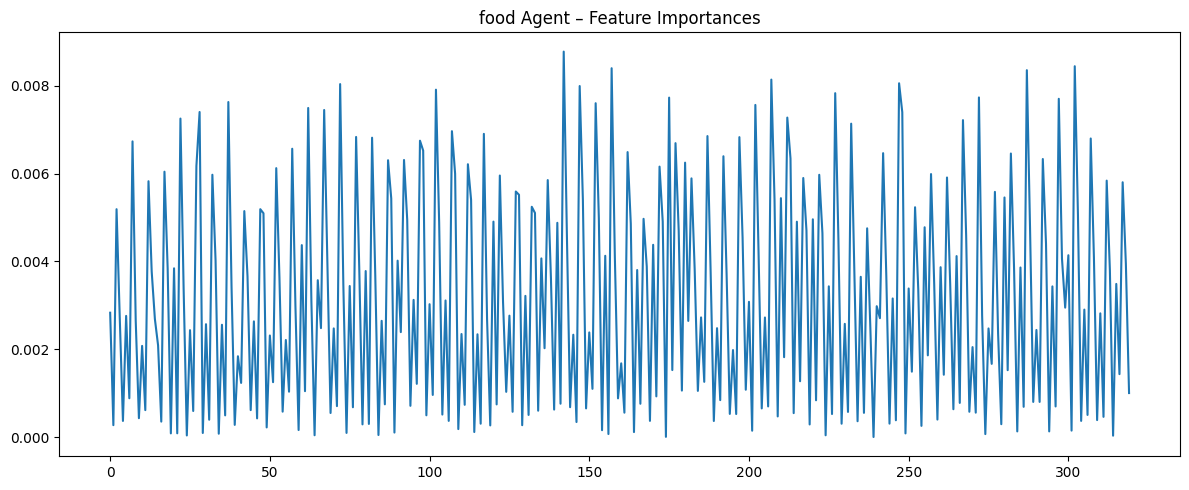

<Figure size 1500x1000 with 0 Axes>

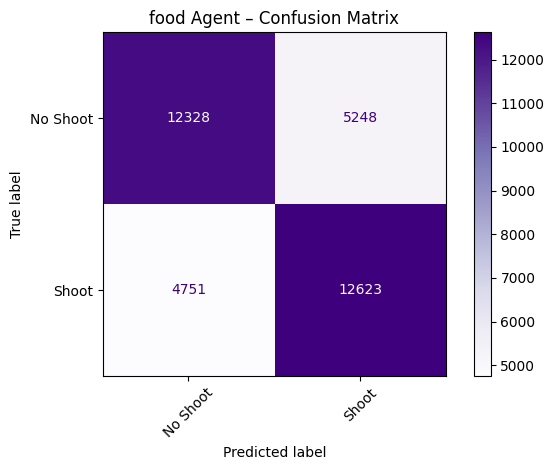

In [98]:
food_disc_tree, food_cont_tree = train_surrogates('food', AGENT_CONFIG['food'])

In [106]:
food_obs = load_observations(AGENT_CONFIG['food']['obs_bin_path'], AGENT_CONFIG['food']['obs_shape'])
obs_flat = downsample_grid(food_obs, patch_size=4)

food_actions = np.load(AGENT_CONFIG['food']['action_path'])
food_disc_actions = food_actions[:, AGENT_CONFIG['food']["num_continuous"]].astype(int)
food_cont_actions = food_actions[:, :AGENT_CONFIG['food']["num_continuous"]]    


feature_names = [get_grid_feature_label(i, grid_size=10) for i in range(500)]


food_disc_tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
food_disc_tree_clf.fit(obs_flat, food_disc_actions)
print(export_text(food_disc_tree_clf, feature_names=feature_names))

#plot decison tree
dot_data = export_graphviz(
    food_disc_tree_clf,
    out_file=None,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=5  # optional
)
graph = graphviz.Source(dot_data)
graph.render("food_tree", format='png', cleanup=True)

|--- [BadFood] at (3,2) <= 0.03
|   |--- [Food] at (4,0) <= 0.34
|   |   |--- [BadFood] at (6,3) <= 0.59
|   |   |   |--- [BadFood] at (2,7) <= 0.41
|   |   |   |   |--- [FrozenAgent] at (3,5) <= 0.03
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- [FrozenAgent] at (3,5) >  0.03
|   |   |   |   |   |--- class: 1
|   |   |   |--- [BadFood] at (2,7) >  0.41
|   |   |   |   |--- [Wall] at (8,4) <= 0.28
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- [Wall] at (8,4) >  0.28
|   |   |   |   |   |--- class: 0
|   |   |--- [BadFood] at (6,3) >  0.59
|   |   |   |--- [BadFood] at (2,8) <= 0.12
|   |   |   |   |--- class: 0
|   |   |   |--- [BadFood] at (2,8) >  0.12
|   |   |   |   |--- class: 1
|   |--- [Food] at (4,0) >  0.34
|   |   |--- [Food] at (6,4) <= 0.09
|   |   |   |--- [Food] at (4,6) <= 0.06
|   |   |   |   |--- [Wall] at (9,5) <= 0.03
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- [Wall] at (9,5) >  0.03
|   |   |   |   |   |--- class: 0
|   |   |   |--- [Fo

'food_tree.png'

In [85]:
testOut = explain_tree_in_natural_language(food_disc_tree_clf, feature_names)
print(testOut)

IF BadFood occupies ≤ 3% of patch (3,2):
  IF Food occupies ≤ 34% of patch (4,0):
    IF BadFood occupies ≤ 59% of patch (6,3):
      IF BadFood occupies ≤ 41% of patch (2,7):
        IF FrozenAgent occupies ≤ 3% of patch (3,5):
          THEN class 0
        ELSE:
          THEN class 1
      ELSE:
        IF Wall occupies ≤ 28% of patch (8,4):
          THEN class 1
        ELSE:
          THEN class 0
    ELSE:
      IF BadFood occupies ≤ 12% of patch (2,8):
        THEN class 0
      ELSE:
        THEN class 1
  ELSE:
    IF Food occupies ≤ 9% of patch (6,4):
      IF Food occupies ≤ 6% of patch (4,6):
        IF Wall occupies ≤ 3% of patch (9,5):
          THEN class 1
        ELSE:
          THEN class 0
      ELSE:
        THEN class 0
    ELSE:
      THEN class 0
ELSE:
  IF Wall occupies ≤ 41% of patch (4,1):
    IF Wall occupies ≤ 59% of patch (0,3):
      IF Wall occupies ≤ 16% of patch (0,8):
        IF BadFood occupies ≤ 16% of patch (4,7):
          THEN class 1
        EL

In [86]:
labels = [label_continuous_action(a) for a in food_cont_actions]

le = LabelEncoder()
y = le.fit_transform(labels)
class_lookup = {i: label for i, label in enumerate(le.classes_)}

cont_tree = DecisionTreeRegressor(max_depth=7)
cont_tree.fit(obs_flat, food_cont_actions)
print(export_text(cont_tree, feature_names=feature_names))
print(explain_regression_tree_in_natural_language(
    cont_tree,
    feature_names,
    label_func=label_continuous_action
))


|--- [Wall] at (0,9) <= 0.34
|   |--- [Wall] at (0,6) <= 0.28
|   |   |--- [Wall] at (0,5) <= 0.41
|   |   |   |--- [Wall] at (1,4) <= 0.09
|   |   |   |   |--- [Wall] at (0,2) <= 0.34
|   |   |   |   |   |--- [Wall] at (1,0) <= 0.28
|   |   |   |   |   |   |--- [Wall] at (1,8) <= 0.34
|   |   |   |   |   |   |   |--- value: [-0.11, 0.12, -0.06]
|   |   |   |   |   |   |--- [Wall] at (1,8) >  0.34
|   |   |   |   |   |   |   |--- value: [-0.30, -0.02, -0.23]
|   |   |   |   |   |--- [Wall] at (1,0) >  0.28
|   |   |   |   |   |   |--- [Wall] at (0,1) <= 0.09
|   |   |   |   |   |   |   |--- value: [-0.33, 0.00, -0.25]
|   |   |   |   |   |   |--- [Wall] at (0,1) >  0.09
|   |   |   |   |   |   |   |--- value: [-0.20, 0.29, -0.11]
|   |   |   |   |--- [Wall] at (0,2) >  0.34
|   |   |   |   |   |--- [Wall] at (1,2) <= 0.22
|   |   |   |   |   |   |--- [Wall] at (0,0) <= 0.09
|   |   |   |   |   |   |   |--- value: [-0.16, 0.07, -0.12]
|   |   |   |   |   |   |--- [Wall] at (0,0) >  0.09


--- Training surrogate for 'pyramid' ---
Actions taken shape: (12696,)
Loaded 12696 actions taken
→ Action distribution: [  23 7386    0 5282    5]
12696 12696
               precision    recall  f1-score   support

    No Action       1.00      1.00      1.00        23
 Move Forward       0.98      1.00      0.99      7386
Move Backward       0.00      0.00      0.00         0
   Turn Right       1.00      0.98      0.99      5282
    Turn Left       1.00      1.00      1.00         5

     accuracy                           0.99     12696
    macro avg       0.80      0.79      0.80     12696
 weighted avg       0.99      0.99      0.99     12696

✔ Discrete action surrogate F1 score: 0.989
✔ Discrete action surrogate accuracy: 0.989


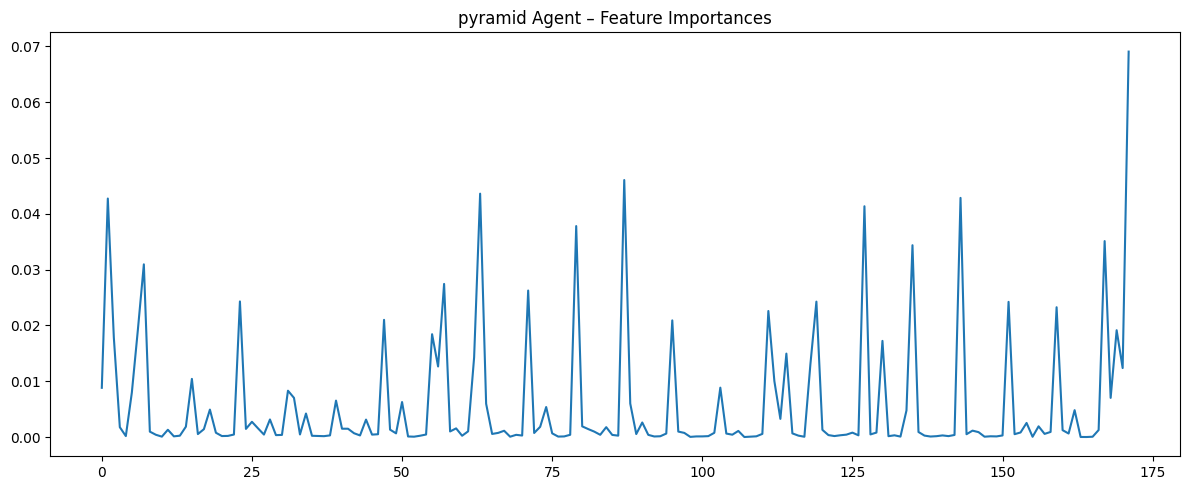

<Figure size 1500x1000 with 0 Axes>

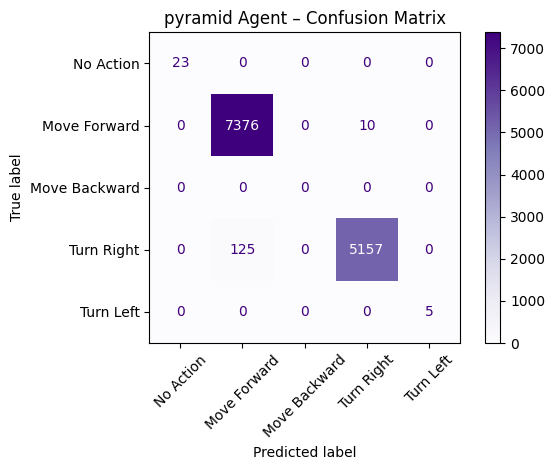

In [99]:
pyramid_disc, _ = train_surrogates('pyramid', AGENT_CONFIG['pyramid'])


--- Training surrogate for 'dungeon' ---
→ Action distribution: [3182 4777 3766 4152 2544 2123 3490]
24034 24034
               precision    recall  f1-score   support

    No Action       0.77      0.83      0.80      3182
 Move Forward       0.81      0.88      0.85      4777
Move Backward       0.72      0.88      0.79      3766
   Turn Right       0.85      0.86      0.86      4152
    Turn Left       0.97      0.80      0.88      2544
  Strafe Left       0.99      0.87      0.92      2123
 Strafe Right       0.99      0.76      0.86      3490

     accuracy                           0.84     24034
    macro avg       0.87      0.84      0.85     24034
 weighted avg       0.86      0.84      0.85     24034

✔ Discrete action surrogate F1 score: 0.843
✔ Discrete action surrogate accuracy: 0.843


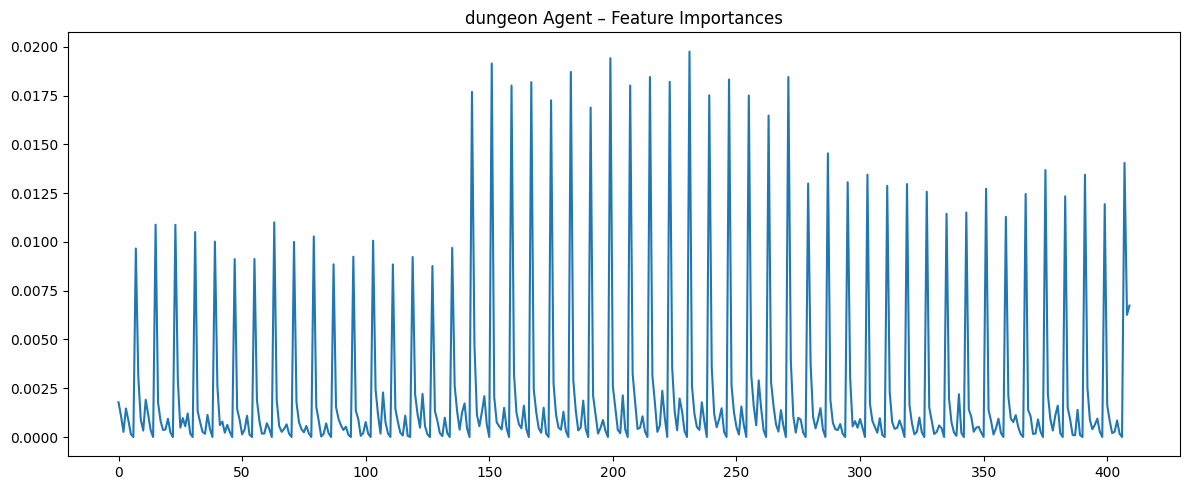

<Figure size 1500x1000 with 0 Axes>

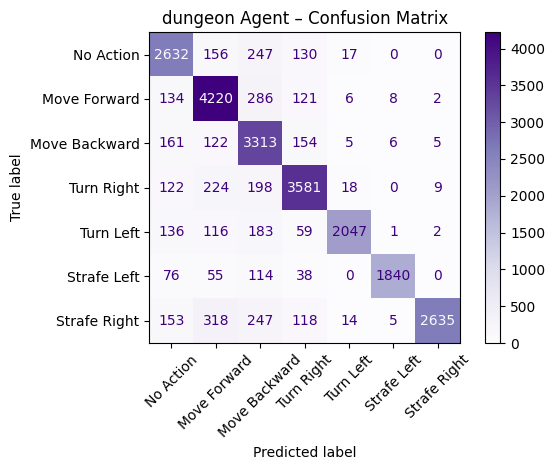

In [100]:
dungeon_disc, _ = train_surrogates("dungeon", AGENT_CONFIG["dungeon"])

## Train and display interpretable decision tree for the Pyramid agent

In [ ]:
# Load and preprocess pyramid observations and actions
pyramid_obs = load_observations(AGENT_CONFIG['pyramid']['obs_bin_path'], AGENT_CONFIG['pyramid']['obs_shape'])
pyramid_obs_flat = preprocess_pyramid_rays_trimmed(pyramid_obs.reshape((pyramid_obs.shape[0], -1)))
pyramid_actions = np.fromfile(AGENT_CONFIG['pyramid']['action_path'], dtype=np.int32).reshape(-1, 2)
pyramid_disc_actions = pyramid_actions[:, 1]

# Feature names for pyramid agent (21 rays + 4 floats)
pyramid_feature_names = [f"RayDist_{i}" for i in range(21)] + [f"AgentFloat_{i}" for i in range(4)]

# Train decision tree
pyramid_tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
pyramid_tree_clf.fit(pyramid_obs, pyramid_disc_actions)
print(export_text(pyramid_tree_clf))

|--- feature_1 <= 0.50
|   |--- feature_171 <= 0.00
|   |   |--- feature_130 <= 0.50
|   |   |   |--- feature_15 <= 0.00
|   |   |   |   |--- feature_87 <= 0.00
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- feature_87 >  0.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_15 >  0.00
|   |   |   |   |--- feature_45 <= 0.50
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- feature_45 >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- feature_130 >  0.50
|   |   |   |--- class: 0
|   |--- feature_171 >  0.00
|   |   |--- feature_40 <= 0.50
|   |   |   |--- feature_5 <= 0.50
|   |   |   |   |--- feature_160 <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_160 >  0.50
|   |   |   |   |   |--- class: 3
|   |   |   |--- feature_5 >  0.50
|   |   |   |   |--- feature_169 <= -0.04
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- feature_169 >  -0.04
|   |   |   |   |   |--- class: 1
|   |   |--- feature_40 >  0.50
|   |   |   |--- featur

In [ ]:
# Optional: Explain the pyramid tree in natural language (if desired)
pyramid_tree_expl = explain_tree_in_natural_language(pyramid_tree_clf, pyramid_feature_names)
print(pyramid_tree_expl)

ValueError: not enough values to unpack (expected 2, got 1)

## Train and display interpretable decision tree for the Dungeon agent

In [ ]:
# Load and preprocess dungeon observations and actions
dungeon_obs_files = sorted(glob.glob(AGENT_CONFIG["dungeon"]["obs_bin_glob"]))
dungeon_action_files = sorted(glob.glob(AGENT_CONFIG["dungeon"]["action_path_glob"]))

dungeon_obs_list = []
dungeon_actions_list = []
for o_path, a_path in zip(dungeon_obs_files, dungeon_action_files):
    obs = load_observations(o_path, AGENT_CONFIG["dungeon"]["obs_shape"])
    acts = np.fromfile(a_path, dtype=np.int32)
    dungeon_obs_list.append(obs)
    dungeon_actions_list.append(acts)

dungeon_obs = np.concatenate(dungeon_obs_list, axis=0)
dungeon_obs_flat = dungeon_obs.reshape((dungeon_obs.shape[0], -1))
dungeon_disc_actions = np.concatenate(dungeon_actions_list, axis=0)

# Feature names for dungeon agent (just index numbers)
dungeon_feature_names = [f"Feature_{i}" for i in range(dungeon_obs_flat.shape[1])]

# Train decision tree
dungeon_tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dungeon_tree_clf.fit(dungeon_obs_flat, dungeon_disc_actions)
print(export_text(dungeon_tree_clf, feature_names=dungeon_feature_names))

|--- Feature_280 <= 0.50
|   |--- Feature_256 <= 0.50
|   |   |--- Feature_71 <= 0.30
|   |   |   |--- Feature_76 <= 0.50
|   |   |   |   |--- Feature_409 <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Feature_409 >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- Feature_76 >  0.50
|   |   |   |   |--- Feature_399 <= 0.12
|   |   |   |   |   |--- class: 5
|   |   |   |   |--- Feature_399 >  0.12
|   |   |   |   |   |--- class: 2
|   |   |--- Feature_71 >  0.30
|   |   |   |--- Feature_379 <= 0.50
|   |   |   |   |--- Feature_258 <= 0.50
|   |   |   |   |   |--- class: 6
|   |   |   |   |--- Feature_258 >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Feature_379 >  0.50
|   |   |   |   |--- Feature_63 <= 0.18
|   |   |   |   |   |--- class: 6
|   |   |   |   |--- Feature_63 >  0.18
|   |   |   |   |   |--- class: 0
|   |--- Feature_256 >  0.50
|   |   |--- Feature_399 <= 0.01
|   |   |   |--- Feature_220 <= 0.50
|   |   |   |   |--- Feature_63 <= 0.02

In [ ]:
# Optional: Explain the dungeon tree in natural language (if desired)
dungeon_tree_expl = explain_tree_in_natural_language(dungeon_tree_clf, dungeon_feature_names)
print(dungeon_tree_expl)